In [1]:
import numpy as np
import pandas as pd
from enum import Enum, auto
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
from matplotlib import cm
import plotly.graph_objects as go
import plotly.express as px

### Wprowadzenie i kalibracja modelu

Zakładamy
\begin{align*}
S^1_n (\omega) = S^1_0(\omega) \exp (sn + m\sum_{i=1}^n \omega_i) \\
\mathbb{P}(\omega_{i+1} = 1 | \mathcal{F}_i) = p \\
\mathbb{P}(\omega_{i+1} = -1 | \mathcal{F}_i) = 1-p
\end{align*}
Potrzebujemy dobrać odpowiednie s, m, p. 

Oznaczmy

\begin{align*}
R_n (\omega) = \log ( \frac {S_n (\omega)} {S_{n-1}(\omega)} ) = s + m\omega_n
\end{align*}
Przy ustalonym p
\begin{align*}
\mathbb{E}[R_n] = s + m(2p-1)\\
Var(R_n) = 4m^2p (1-p)
\end{align*}
tak więc 
\begin{align*}
m = \sqrt{\frac {Var(R_n)} {4p(1-p)}}\\
s = \mathbb{E}[R_n] - m(2p-1) 
\end{align*}
Tak więc ustalając p jesteśmy w stanie estymować s i m korzystając ze zwrotów historycznych. dalej mamy
\begin{align*}
\omega_n = 1 \iff R_n(\omega) = s+m  \\
\omega_n = -1 \iff R_n(\omega) = s-m
\end{align*}
więc
\begin{align}
\frac 1 n \mathbb{E} \Big[ \#  \{k\leq n: {|R_k - (s+m)| < |R_k - (s-m)|}\}\Big] = p  \hspace{10mm} (\star)
\end{align}

Kalibracja modelu będzie więc przebiegać poprzez dobranie takiego $p$, by dla wyestymowanych ze zwrotów historycznych $s$ i $m$ otrzymać możliwie najlepsze dopasowanie w $ (\star )$.

Następnie szukamy miary martyngałowej. Zakładając, że rozkład $\omega_i$ nadal nie zależy od $i$, tj.
\begin{align*}
Q(\omega_{i+1} = 1 | \mathcal{F}_i) = q \\
Q(\omega_{i+1} = -1 | \mathcal{F}_i) = 1-q
\end{align*}
taka miara musi spełniać

\begin{align}
\mathbb{E}_Q [e^{-rn} S_{n} | \mathcal{F}_{n-1}] &= e^{-rn} S_{n-1} \mathbb{E}_Q [\exp (s + m\omega_n)] = e^{-rn}S_{n-1} [q e^{s+m} + (1-q) e^{s-m}] \\&= e^{-rn}S_{n-1} e^s [q e^m + (1-q) e^{-m}] = e^{-r(n-1)}S_{n-1}
\end{align}
czyli
\begin{align}
qe^m + (1-q)e^{-m} = e^{r-s} \implies q = \frac {e^{r-s} - e^{-m}} {e^m - e^{-m}}
\end{align}
do tego aby mieć $q \in (0,1)$ musi zachodzić $m>|r-s|$.

In [36]:
MSFT_PATH = "https://stooq.pl/q/d/l/?s=msft.us&d1=20160301&d2=20170301&i=d" # kurs MSFT 01-03-2016 do 01-03-2017
GOOG_PATH = "https://stooq.pl/q/d/l/?s=goog.us&d1=20160301&d2=20170301&i=d"# kurs GOOG 01-03-2016 do 01-03-2017
TAU_MAX = "\u03C4_MAX"
TAU_MIN = "\u03C4_MIN"

CONST_R = 0.005

In [39]:

def sm(p,returns): #estymacja s i m przy ustalonym p
  e = np.mean(returns)
  v = np.mean(returns**2) - e**2
  m = np.sqrt(v/(4*p*(1-p)))
  s = e - m*(2*p -1)
  return s,m


def p_est(p,returns): #estymacja p przy użyciu (*)
  (s,m) = sm(p,returns)
  return np.count_nonzero(np.abs(returns - (s+m)) < np.abs(returns - (s-m)))/len(returns)

def p_opt(returns, stock_name, N=10000):
  p = np.array(range(1,N))/N
  p_fit = np.zeros(N-1)
  for i in range(0,N-1):
    p_fit[i] = np.abs(p[i] - p_est(p[i],returns))
  plt.plot(p,p_fit)
  plt.xlabel("X axis label")
  plt.ylabel("|p - p_estimated|")
  plt.title(f"estimate of p for {stock_name}")
  return p[np.where(p_fit == np.amin(p_fit))]

class ModelParams():
  def __init__(self, p, s, m, q, r = CONST_R):
    self.p = p
    self.s = s
    self.m = m
    self.q = q
    self.r = r

  def __str__(self):
    return f"p = {self.p.round(decimals=5)}\ns = {self.s.round(decimals=5)}\nm = {self.m.round(decimals=5)}\nq = {self.q.round(decimals=5)}" 

def read_data(path):
  df = pd.read_csv(path)
  df['Data'] = pd.to_datetime(df['Data'])
  return df

def GetMartingaleMeasure(s, m, r = CONST_R): #returns q
  q = (np.exp(r-s) - np.exp(-1*m))/(np.exp(m) - np.exp(-m))
  assert q > 0
  assert q < 1
  return q 

def estimate_params(df, stock_name):
  logreturns =  np.log1p(df.Otwarcie.pct_change())[1:].to_numpy() #zwroty logarytmiczne, ceny z otwarcia
  p = p_opt(logreturns, stock_name)
  (s,m) = sm(p,logreturns)
  p, m, s = p[0], m[0], s[0]
  q = GetMartingaleMeasure(s, m)
  return ModelParams(p, s, m, q)  

p = 0.5238
s = 0.00046
m = 0.01174
q = 0.69097


Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie   Wolumen
0   2016-03-01    46.539     48.021     46.496      48.011  33081802
1   2016-03-02    47.855     48.359     47.624      48.349  29199079
2   2016-03-03    48.369     48.369     47.280      47.799  25397720
3   2016-03-04    47.845     47.891     47.220      47.509  34698049
4   2016-03-07    47.081     47.299     46.184      46.596  41279142
..         ...       ...        ...        ...         ...       ...
248 2017-02-23    60.371     60.660     60.161      60.555  20656584
249 2017-02-24    60.472     60.729     60.102      60.555  22823290
250 2017-02-27    60.482     60.482     60.018      60.192  16593665
251 2017-02-28    60.050     60.165     59.753      59.958  23150312
252 2017-03-01    60.098     60.903     59.997      60.828  23843896

[253 rows x 6 columns]

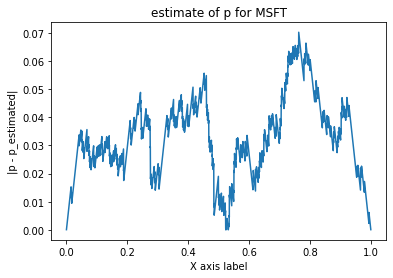

In [40]:
msft = read_data(MSFT_PATH)
msft_params = estimate_params(msft, "MSFT")
print(msft_params)
msft

p = 0.5
s = 0.00065
m = 0.01043
q = 0.70645


Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie  Wolumen
0   2016-03-01    703.62    718.810     699.77      718.81  1453825
1   2016-03-02    719.00    720.000     712.00      718.85  1082731
2   2016-03-03    718.68    719.450     706.02      712.42  1895828
3   2016-03-04    714.99    716.490     706.02      710.89  1306306
4   2016-03-07    706.90    708.091     686.90      695.16  2734897
..         ...       ...        ...        ...         ...      ...
248 2017-02-23    830.12    832.460     822.88      831.33  1192820
249 2017-02-24    827.73    829.000     824.20      828.64  1376546
250 2017-02-27    824.55    830.500     824.00      829.28  1048782
251 2017-02-28    825.61    828.540     820.20      823.21  1638677
252 2017-03-01    828.85    836.255     827.26      835.24  1412695

[253 rows x 6 columns]

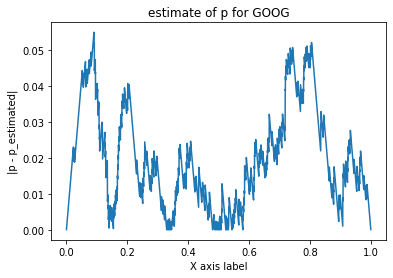

In [41]:
goog = read_data(GOOG_PATH)
goog_params = estimate_params(goog, "GOOG")
print(goog_params)
goog

### Teoria do wyceny opcji

Potrzeba wyliczonych:
- $q$ - miara mtg, że $w_i = 1$
- $s, m$ - z kalibracji modelu
 

Otoczka Snella dana wzorami
\begin{align}
U_T &= H_T \\
U_{t} &= \max( H_t, \mathbb{E^*}[U_{t+1} | \mathcal{F}_t])
\end{align}
Rozkład Dooba $ U_t = M_t - A_t $, gdzie $M_t$ - adaptowalny martyngał, a $A_t$ - przewidywalny. Dane wzorami
\begin{align}
A_0 &= 0, \\ 
A_t &= A_{t-1} + U_{t-1} - \mathbb{E^*}[U_t | \mathcal{F}_{t-1}]
\end{align}
oraz 
$$
M_t = U_t + A_t.
$$

Wtedy rzeczywiście, 
- $A_t$ jest przewidywalny 
- $M_t$ jest martyngałem:

\begin{align}
 \mathbb{E^*}[M_t | \mathcal{F}_{t-1}] &= \mathbb{E^*}[U_t | \mathcal{F}_{t-1}] + \mathbb{E^*}[A_t | \mathcal{F}_{t-1}] = \mathbb{E^*}[U_t | \mathcal{F}_{t-1}] + A_t = \\
 &= \mathbb{E^*}[U_t | \mathcal{F}_{t-1}] + A_{t-1} + U_{t-1} - \mathbb{E^*}[U_t | \mathcal{F}_{t-1}] =
  M_{t-1}.
 \end{align}



### Uwagi odnośnie praktycznej wyceny na komputerze.

W naszym modelu, drzewko ceny aktywa podstawowego ma rozmiar wykładniczy (poza liśćmi, każdy wierzchołek ma dwóch synów). Jednak na cenę aktywa podstawowego $S_t$ w chwili $t$ wpływa tylko liczba wzrostów = $|\{ i : w_i = 1\}|$  oraz spadków  = $|\{ i : w_i = -1\}|$  do chwili $t$, a nie ich kolejność. Zatem aby wyceniać opcje, które nie zależą od trajektorii, możemy utożsamić wierzchołki o tej samej cenie aktywa podstawowego. Otrzymujemy dzięki temu drzewko o kwadratowej liczbie wierzchołków. Takie drzewko nazwiemy rekombinującym się.

Bez problemu wyliczmy procesu $U_t$ na rekombinującym się drzewku. Pojawia się jednak problem przy wyliczeniu procesu $A_t$. Przypomnijmy, 

$$
A_t = A_{t-1} + U_{t-1} - \mathbb{E^*}[U_t | \mathcal{F}_{t-1}].
$$
Czyli $A_t$ zależy od $A_{t-1}$, którego w drzewku rekombinującym nie znamy! Aby obejść ten problem będziemy liczyć proces roźnic dla procesu $A_t.$ Dokładniej, niech
$$
K_t := A_{t+1} - A_t = U_t - \mathbb{E^*}[U_{t+1} | \mathcal{F}_{t}] = \max( H_t - \mathbb{E^*}[U_{t+1} | \mathcal{F}_t], 0),
$$
zdefiniowany dla $t = 0 \dots T-1$.


### Optymalne czasy wykonania opcji: $\tau_\min$ i $\tau_\max.$

Najwcześniejszy optymalny czas wykonania $\tau_\min$ wyraża się poprzez
$$
\tau_\min = \inf \{ t \geq 0 | U_t = H_t \}.
$$

Najpóźniejszy optymalny czas zatrzymania $\tau_{\max}$ wyraża się poprzez $K_t$. Mianowicie:
$$
\tau_\max = \inf \{ t \geq 0 | A_{t+1} \neq 0  \} \vee T = \inf \{ t \geq 0 | K_{t} \neq 0  \} \vee T. 
$$


Poniżej dwa przykłady ww. procesów.

#### Przykłady 

1. Standardowa opcja amerykańska put.
![](https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/project_2/ex1_put.png)


1. Opcja amerykańska put z twistem.
![](https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/project_2/ex2_put%2Btwist.png)

In [37]:
TRAIN_START = np.min(msft['Data'])
TRAIN_END = np.max(msft['Data'])

### Jak rozszerzyć model o dywidendy?

- GOOG: nie wypłaca dywidend
- MSFT: wypłaca *przewidywalne* wydidendy

In [4]:
def GetMstfDividendsData():
  auth.authenticate_user()
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  worksheet = gc.open('MSFT dividends').sheet1
  rows = worksheet.get_all_values()
  msft_dividends = pd.DataFrame(rows[1:], columns=rows[0])
  for date_type in {'decl_date', 'ex_date', 'paid_date'}:
    msft_dividends[date_type] = pd.to_datetime(msft_dividends[date_type])
  return msft_dividends

In [5]:
msft_dividends = GetMstfDividendsData()

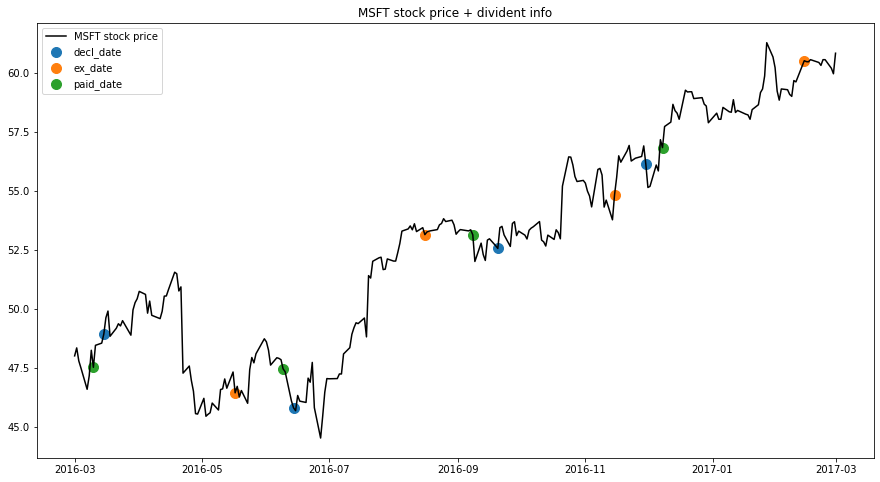

In [6]:
figure(figsize=(15, 8))

plt.plot(msft['Date'], msft['Close'], label='MSFT stock price', color='black')

for date_type in ['decl_date', 'ex_date', 'paid_date']:

  df = msft_dividends[(msft_dividends[date_type] >= TRAIN_START) &(msft_dividends[date_type] <= TRAIN_END)]
  df = df.rename(columns={date_type: 'Date'})
  df = df.join( msft.set_index('Date'), on='Date', how='inner')
  plt.scatter(df['Date'], df['Close'], label=date_type, s=100)

plt.title('MSFT stock price + divident info')
plt.legend()


In [7]:
%precision %.2f
for date_type in ['decl_date', 'ex_date', 'paid_date']:
  print(date_type)
  df = msft_dividends[(msft_dividends[date_type] >= TRAIN_START) &(msft_dividends[date_type] <= TRAIN_END)]
  df = df.rename(columns={date_type: 'Date'})
  df = msft.join( df.set_index('Date'), on='Date', how='inner')
  for i in list([df.index-1][0] ):
    diff = msft.loc[i+1]['Close'] - msft.loc[i]['Close']
    ratio = 100* diff /  msft.loc[i]['Close']
    print("date: ", msft.loc[i]['Date'], " diff: ", np.round(diff, 2), " ratio: ", np.round(ratio, 2))
    # print("date: ", msft.loc[i]['Date'], " before: ", msft.loc[i]['Close'], " after: ", msft.loc[i+1]['Close'], " diff: ", diff)
  # print( msft.loc[list([df.index-1][0] ) ])


decl_date
date:  2016-03-14 00:00:00  diff:  0.38  ratio:  0.79
date:  2016-06-13 00:00:00  diff:  -0.29  ratio:  -0.62
date:  2016-09-19 00:00:00  diff:  -0.11  ratio:  -0.21
date:  2016-11-29 00:00:00  diff:  -0.77  ratio:  -1.36
ex_date
date:  2016-05-16 00:00:00  diff:  -0.88  ratio:  -1.86
date:  2016-08-15 00:00:00  diff:  -0.29  ratio:  -0.55
date:  2016-11-14 00:00:00  diff:  1.06  ratio:  1.98
date:  2017-02-13 00:00:00  diff:  0.23  ratio:  0.38
paid_date
date:  2016-03-09 00:00:00  diff:  -0.72  ratio:  -1.5
date:  2016-06-08 00:00:00  diff:  -0.38  ratio:  -0.8
date:  2016-09-07 00:00:00  diff:  -0.22  ratio:  -0.4
date:  2016-12-07 00:00:00  diff:  -0.34  ratio:  -0.59


MSFT dywidendy: https://stooq.pl/q/m/?s=msft.us.

Dywidendy wypłacane w dniach:
- wto, 16 maj 2017
- wto, 15 sie 2017
- śro, 15 lis 2017
- śro, 14 lut 2018

Przyjmujemy, że dywidendy będą wypłacane co kwartał w wysokości 0.60%.

In [127]:
mstf_dividends = {
    31: 0.006,
    93: 0.006,
    155: 0.006,
    217: 0.006
}

## Wycena Opcji

In [128]:
class OptionType(Enum):
  AMERICAN_CALL = auto()
  AMERICAN_PUT = auto()

class Option:
  def __init__(self, type, days_till_expiry, threshold, under_asset_name):
    """
    Args: 
      - type one of OptionType
      - days_till_expiry
      - threshold
    """
    self.type = type
    self.days_till_expiry = days_till_expiry
    self.threshold = threshold
    self.under_asset_name = under_asset_name
    if self.type == OptionType.AMERICAN_CALL:
      self.payoff = lambda x : max(x - self.threshold, 0)
    elif self.type == OptionType.AMERICAN_PUT:
      self.payoff = lambda x : max(self.threshold - x, 0)
    else: 
      raise Exception(f"Unknown option type: {self.type}.")

  def Payoff(self, s):
    return self.payoff(s)

  def __str__(self):
    return f"{self.type.name} on {self.under_asset_name} @ {self.threshold}, expiry in {self.days_till_expiry} days."

  
def _on_board(i, j):
  return i >= 0 and j >= 0 and j <= i

def _get_info(prev_i, prev_j, i, j, U, H, K, eps=1e-9):
  if not _on_board(prev_i, prev_j):
    if K[i][j] > 0:
      return TAU_MAX
    elif U[i][j] == H[i][j]:
      return TAU_MIN
    else:
      return None
  
  if abs(K[prev_i][prev_j]) < eps and K[i][j] > 0:
    return TAU_MAX
  if U[prev_i][prev_j] >  H[prev_i][prev_j] and U[i][j] == H[i][j]:
    return TAU_MIN
  return None

def get_info(i, j, U, H, K):
  if i == 0 and j == 0:
    if K[i][j] > 0:
      return TAU_MAX
    elif U[i][j] == K[i][j]:
      return TAU_MIN
    else:
      return None
  
  above_parent = _on_board(i-1, j)
  below_parent = _on_board(i-1, j-1)

  if K[i][j] > 0:
    if above_parent and K[i-1][j] == 0: 
      return TAU_MAX
    if below_parent and K[i-1][j-1] == 0: 
      return TAU_MAX
  
  if U[i][j] == H[i][j]:
    if above_parent and U[i-1][j] > H[i-1][j]:
      return TAU_MIN
    if below_parent and U[i-1][j-1] > H[i-1][j-1]:
      return TAU_MIN

  return None


def VanillaAmericanOptionStats(model_params, tdy_asset_price, option, dividends=dict()):
  """
  Args:
    - q - miara mtg, że w_i = 1
    - s, m, r - z kalibracji modelu
    - tdy_asset_price - dzisiejsza cena instrumentu podstawowego
    - option - opcja do wyceny
  Returns:
    - S[][] - drzewko cen aktywa bazowego: tablica trójkątna: S[n = numer_dnia][liczba w_i == 1 dla i \in {0, 1, ..., n} ].
    - U[][] - otoczka Snella; tablica trójkątna jak wyżej.
    - K[][] - przyrosty procesu przewidywalnego z rozkładu Dooba -  tablice trójkątna wymiaru (n-1) x (n-1)
    - Opt[][] - optymalne czasy wykonania - tablica True/ False; tablica trójkątna jak wyżej wymiaru (n-1) x (n-1)
    - days[][] - numery dnia dopowiadajace indeksom tj. days[i][j] = i
    - df - pandas.DataFrame days, S, U, K w 'long format' - na potrzeby wykresów
  """
  s, m, r, q = model_params.s, model_params.m, model_params.r, model_params.q
  N = option.days_till_expiry + 1
  S = np.zeros((N, N))
  S[0][0] = tdy_asset_price
  U = np.zeros_like(S)
  H = np.zeros_like(S)
  K = np.zeros((N-1, N-1))
  Opt = np.zeros_like(K, dtype=bool)
  df_rows = []
  for i in range(1, N):
    S[i][0] = S[i-1][0] * np.exp(s - m)
    if i in dividends:
      S[i][0] *= (1.- dividends[i])
      
    for j in range(1, i+1):
      S[i][j] = S[i-1][j-1]*np.exp(s + m)
      if i in dividends:
        S[i][j] *= (1. - dividends[i])
  # W liściach, U[N-1][_] to zdyskontowany payoff.
  for i in range(0, N):
    U[N-1][i] = option.Payoff(S[N-1][i]) * np.exp(-r*(N-1))
    H[N-1][i] = U[N-1][i]
    df_rows.append({'day':N-1, 'S': S[N-1][i], 'U': U[N-1][i], 'K':None, 'K_positive' : None, 'U==H': True, 'info':TAU_MAX })

  # Wyliczamy pozostałe wartości U[][].
  for i in range(N-2, -1, -1):
    for j in range(0, i+1):
      cond_exp = q *  U[i+1][j+1] + (1.-q) * U[i+1][j]
      early_exercise = option.Payoff(S[i][j]) * np.exp(-r*i)
      H[i][j] = early_exercise
      U[i][j] = max(cond_exp, early_exercise)
      if early_exercise >= cond_exp:
        Opt[i][j] = True
      K[i][j] = U[i][j] - cond_exp


  for i in range(N-2, -1, -1):
    for j in range(0, i+1):
      # info = _get_info(i-1, j-1, i, j, U, H, K)
      # if info is None:
      #   info = get_info(i-1, j, i, j, U, H, K)
      info = get_info(i, j, U, H, K)
      df_rows.append({'day':i, 'S': S[i][j], 'U': U[i][j], 'K':K[i][j], 'K_positive' : K[i][j] > 0, 'U==H': U[i][j] == H[i][j], 'info': info })
  
  days = np.arange(N)[None, :]
  days = np.tile(days.T, (1, N))

  df = pd.DataFrame(df_rows)
  df['K_positive'] = df['K_positive'].astype(str)
  df['U==H'] = df['U==H'].astype(str)
  df['info'] = df['info'].astype(str)

  df['S_log'] = np.log(df['S'])

  return S, U, K, Opt, days, df


Będziemy rozważać opcje
- AC(GOOG, 900)
- AP(GOOG, 900)
- AC(MSFT, 60)
- AP(MSFT, 60)
- Barierowa bermudzka opcja put na MSFT z kursem wykoanania 60 i barierą typu *down-and-out* o wartości 45, którą można wykonać w dniach 01-06-2017, 01-09-2017, 01-12-2017, 01-03-2018.

In [129]:
def _set_opacity(info):
  return 0.2 if info == 'None' else 1.0

def _set_color(info):
  if info == TAU_MAX:
    return 'black'
  if info == TAU_MIN:
    return 'green'
  return 'orange'

def plot_opt_times(option, df):
  fig = go.Figure(data=[go.Scatter(
      x=df['day'],
      y=df['S'],
      mode='markers',
      marker=dict(
          color=list(map(_set_color, df['info'])),             
          # color_discrete_map = {TAU_MAX: 'black', TAU_MIN: 'green', 'None':'orange'},
          opacity=list(map(_set_opacity, df['info']) ),
          # showlegend = True
      )
  )])
  fig.update_layout(title = str(option), xaxis_title='day', yaxis_title='S')
  fig.update_yaxes(type='log')

  # tight layout
  # fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

  return fig

In [130]:
NUM_TR_DAYS = 200
options = [ Option(OptionType.AMERICAN_CALL, NUM_TR_DAYS, 900, 'GOOG'), 
            Option(OptionType.AMERICAN_PUT, NUM_TR_DAYS, 900, 'GOOG'), 
            Option(OptionType.AMERICAN_CALL, NUM_TR_DAYS, 60, 'MSFT'), 
            Option(OptionType.AMERICAN_PUT, NUM_TR_DAYS, 60, 'MSFT')]


plots = {}
for i, option in enumerate(options):
  df = msft
  model_params = msft_params
  dividends = mstf_dividends
  if option.under_asset_name == 'GOOG':
    df = goog
    model_params = goog_params
    dividends = dict()
  
  tdy_under_asset_price = df.iloc[-1].Otwarcie
  S, U, K, Opt, days, df = VanillaAmericanOptionStats(model_params, tdy_under_asset_price, option, dividends)
  # plots[i] = px.scatter(df, x='day', y='S', opacity=0.7, color='K_positive', color_discrete_map = {'True': 'darkorange', 'False': 'green'}, hover_data=['K', 'S'], title=str(option), log_y=True)
  plots[i] = (px.scatter(df, x='day', y='S', opacity=0.7, color='K', hover_data=['K', 'S'], title=str(option), log_y=True, color_continuous_scale=px.colors.sequential.Jet),
              px.scatter(df, x='day', y='S', opacity=0.7, color='U==H', color_discrete_map = {'True': 'darkorange', 'False': 'green'}, hover_data=['K', 'S'], title=str(option), log_y=True),
              plot_opt_times(option, df))



In [111]:
plots[0][0]

In [131]:
plots[0][1]

In [132]:
plots[0][2]

In [133]:
plots[1][0]

In [134]:
plots[1][1]

In [135]:
plots[1][2]

In [136]:
plots[2][0]

In [137]:
plots[2][1]

In [138]:
plots[2][2]

In [139]:
plots[3][0]

In [140]:
plots[3][1]

In [141]:
plots[3][2]

# PLAYGROUND

In [ ]:
%precision 2
u


(array([[1.00e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [1.35e+00, 5.46e+02, 0.00e+00, 0.00e+00, 0.00e+00],
        [1.83e-01, 7.39e+01, 2.98e+04, 0.00e+00, 0.00e+00],
        [2.48e-02, 1.00e+01, 4.03e+03, 1.63e+06, 0.00e+00],
        [3.35e-03, 1.35e+00, 5.46e+02, 2.20e+05, 8.89e+07]]),
 array([[0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 3.53e-01, 5.45e+02, 2.20e+05, 8.89e+07]]))

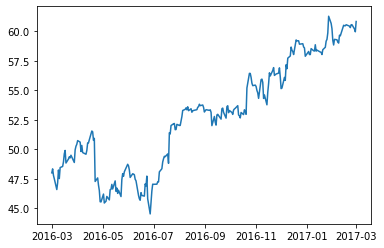

In [ ]:

plt.plot(msft['Date'], msft['Close'])

In [ ]:
# msft_dividends  = pd.DataFrame({
#     'Decl_Date':['2016-03-15', '2016-06-14', '2016-11-30', '2017-03-14' ], 
#     'Ex_Date':['2016-05-17', '2016-08-16', '2017-02-14', '2017-05-16'], 
#     'Pay_Date':['2016-06-09', '2016-09-08', '2017-03-09', ], 
#     'Amount':[0.36, 0.4, ]})
# msft_dividends

Decl_Date     Ex_Date    Pay_Date  Amount
0  2016-03-15  2016-05-17  2016-06-09    0.36